In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import ticker, cm

from scipy.constants import golden
plt.style.use('default')
plt.rc('figure', figsize=((7.0, 7.0 / golden)))

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'
wcolors = ['blue', 'orange']
myindex = [
    '7:00', '8:00', '9:00', '10:00',
    '11:00', '12:00', '13:00', '14:00',
    '15:00','16:00', '17:00', '18:00',
    '19:00', '20:00', '21:00', '22:00',
    '23:00']

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
tragitti = tragitti[clean(tragitti)]


center_point = (45.464216, 9.191949)
point_500m_far = (45.464216, 9.191949 + 0.006528)
center_point_radius = math.sqrt(
    (point_500m_far[0] - center_point[0])**2. +
    (point_500m_far[1] - center_point[1])**2.) # 0.5 km di raggio dal duomo di milano

def pass_through_center(tratta, distanza):
    start_point = tratta[0]
    end_point = tratta[1]
    medium_point = (float(start_point[0] + end_point[0]) / 2., float(start_point[1] + end_point[1]) / 2.)
    
    center_point = (45.464216, 9.191949) # Duomo di Milano
    point_500m_far = (45.464216, 9.191949 + float(distanza * 2) * 0.006528)
    center_point_radius = math.sqrt(
        (point_500m_far[0] - center_point[0])**2. +
        (point_500m_far[1] - center_point[1])**2.) # (distanza*2) * 0.5 km di raggio dal Duomo di Milano
    
    if ((medium_point[0] - center_point[0])**2. + (medium_point[1] - center_point[1])**2. <= center_point_radius**2.):
        return True
    else:
        return False

def filter_center(tragitti, distanza):
    return tragitti.apply(lambda p: pass_through_center(((p['Lat'], p['Lon']), (p['Elat'], p['Elon'])), distanza), axis=1)

In [3]:
tragitti = tragitti[clean(tragitti)]

def heatmap_orario_distanza_centro(mezzo):
    data = []
    for distanza in np.arange(3.5, 0.1, -0.5):
        riga = []
        for ora in range(7, 24):
            tragitti_ora = tragitti[tragitti['Hour'] == ora]
            selected = tragitti_ora[
                (~filter_center(tragitti_ora, distanza - 0.5)) &
                filter_center(tragitti_ora, distanza)]
            vmedia_selected = (selected[distance_param] * 60.) / selected[mezzo]
            riga.append(int(vmedia_selected.mean()))
        data.append(riga)


    ore = ['7:00', '8:00', '9:00', '10:00',
        '11:00', '12:00', '13:00', '14:00',
        '15:00','16:00', '17:00', '18:00',
        '19:00', '20:00', '21:00', '22:00',
        '23:00']
    distanze = ['(3.0, 3.5]', '(2.5, 3.0]', '(2.0, 2.5]', '(1.5, 2.0]', '(1.0, 1.5]', '(0.5, 1.0]', '(0.0, 0.5]']

    fig, ax = plt.subplots()
    im = ax.imshow(data)

    ax.set_xticks(np.arange(len(ore)))
    ax.set_yticks(np.arange(len(distanze)))

    ax.set_xticklabels(ore)
    ax.set_yticklabels(distanze)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(distanze)):
        for j in range(len(ore)):
            text = ax.text(j, i, data[i][j], ha="center", va="center", color="w")

    ax.set_title("v.media in " + mezzo + " [km/h]")
    fig.tight_layout()
    plt.xlabel('orario')
    plt.ylabel('distanza dal Duomo di Milano [km]')
    plt.show()

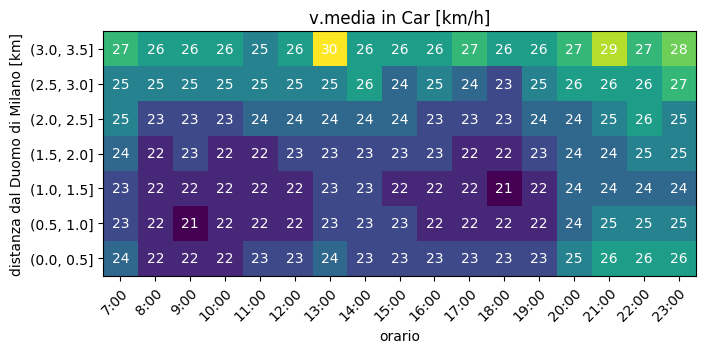

In [4]:
heatmap_orario_distanza_centro('Car')

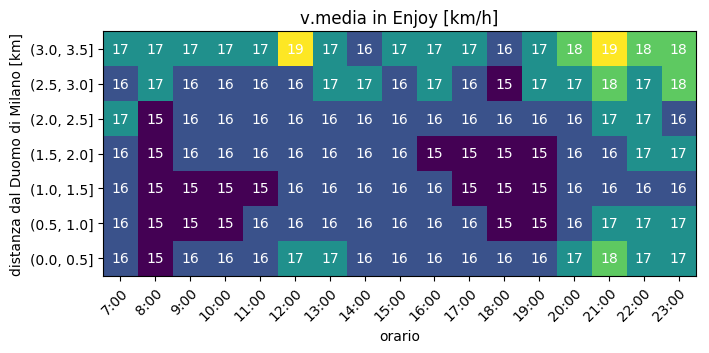

In [5]:
heatmap_orario_distanza_centro('Enjoy')

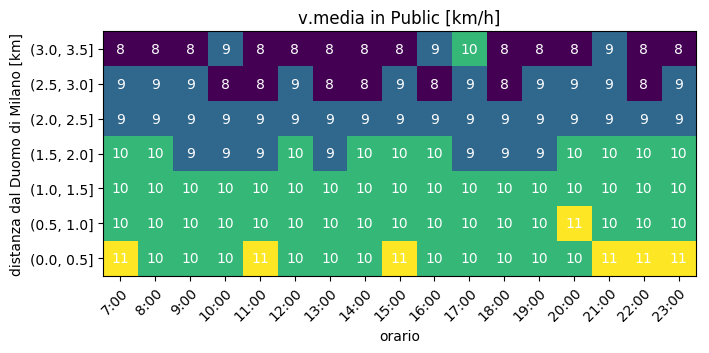

In [6]:
heatmap_orario_distanza_centro('Public')